In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from scipy.spatial.distance import cdist
from scipy.stats.mstats import gmean

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<br>

## $\textrm{Data}$

<br>

$ \textbf{HWCDW} \ \textrm{Nominal compensation per employee: total economy (HWCDW) - 1000CU }$

$ \textbf{NLTN} \ \textrm{Total labour force (Labour force statistics) (NLTN) - 1000 persons }$

$ \textbf{OKND} \ \textrm{Net capital stock at 2010 prices: total economy (OKND) - Mrd CU }$

$ \textbf{OVGD} \ \textrm{Gross domestic product at 2010 reference levels (OVGD) - Mrd CU }$

$ \textbf{UVGE} \ \textrm{Gross value added at current basic prices excluding FISIM: total economy (UVGE) - Mrd CU }$

$ \textbf{ZUTN} \ \textrm{Unemployment rate: total :- Member States: definition EUROSTAT (ZUTN) - (Percentage of active population)  }$

$ \textbf{USGN} \ \textrm{Gross national saving (USGN) - Mrd CU  }$

<br>

In [3]:
def data_handling(data_source, study_countries):
    study_indicators = list(set(data_source.Indicator))
    study_years = [i for i in range(1960, 2020)]
    
    counter = 0
    col = ["country", "year"]; col.extend(study_indicators)
    output = pd.DataFrame(index=col)
        
    for country in study_countries:
        for year in study_years:
            counter += 1
            indicators = [data_source[(data_source.Country == country) & (data_source.Indicator == indicator)][str(year)].values[0] for indicator in study_indicators]
            row_values = [country, int(year)]; row_values.extend(indicators)
            output[counter] = row_values
    
    output_corrected = output.transpose().copy()
    output_corrected.HWCDW *= 1000
    output_corrected.NLTN *= 1000
    output_corrected.OKND *= 10**9
    output_corrected.OVGD *= 10**9
    output_corrected.UVGE *= 10**9
    output_corrected.ZUTN /= 100
    output_corrected.USGN *= 10**9
    
    OVGD = pd.DataFrame(index=list(range(1997,2020)))
    for country in study_countries:
        OVGD[country] = output_corrected[(output_corrected.country == country) & (output_corrected.year >= 1997)].OVGD.values
    OVGD.index = pd.to_datetime(OVGD.index, format='%Y')
    
    return(output_corrected, OVGD)

In [4]:
study_countries = ["Austria", "Belgium", "Cyprus", "Estonia", "Finland", "France", "Germany", 
                   "Greece", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", 
                   "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"]

In [5]:
source = pd.read_csv("./data_source.csv")
data, OVGD = data_handling(source, study_countries)

<br>

## $\textrm{Statistical}$

In [6]:
def statistical(data_input, study_countries):
    data_input=data_input[data_input.year >= 1997]
    
    study_years = [i for i in range(1997, 2020)]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    for country in study_countries:
        country_series = data_input[data_input.country == country].OVGD.values
        cycle, trend = sm.tsa.filters.hpfilter(country_series, 6.25)
        
        output_trend[country] = trend
        output_cycle[country] = cycle
            
    gap = output_cycle.dropna(axis=1).astype(float); gap.index = pd.to_datetime(gap.index, format='%Y')
    potential = output_trend.dropna(axis=1).astype(float); potential.index = pd.to_datetime(potential.index, format='%Y')
            
    return(potential+gap, potential, gap)

In [7]:
statistical_gdp, statistical_potential, statistical_gap = statistical(data, study_countries)

<br>

In [8]:
def graphs_potential(input_gdp, input_potential, input_gap, input_type):
      
    plt.figure()
    (input_potential/input_potential.iloc[0]*100).plot(figsize=(20, 10), colormap="tab20")
    plt.title(r"$Y^{\star}$, Eurozone ("+input_type+")", fontsize=22)
    plt.ylabel(r"$Y^{\star}$")
    plt.xlabel("Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.figure()
    (input_gap/input_gdp*100).plot(figsize=(20, 10), colormap="tab20")
    plt.title("Output Gaps, Eurozone ("+input_type+")", fontsize=22)
    plt.ylabel("Output Gap, \%")
    plt.xlabel("Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    plt.figure()
    (input_gap/input_gdp).std(axis=1).plot(figsize=(20, 10), color="black")
    plt.title("Standard Deviation of Output Gaps, Eurozone ("+input_type+")", fontsize=22)
    plt.ylabel("Standard Deviation")
    plt.xlabel("Year")
    plt.show()

<Figure size 432x288 with 0 Axes>

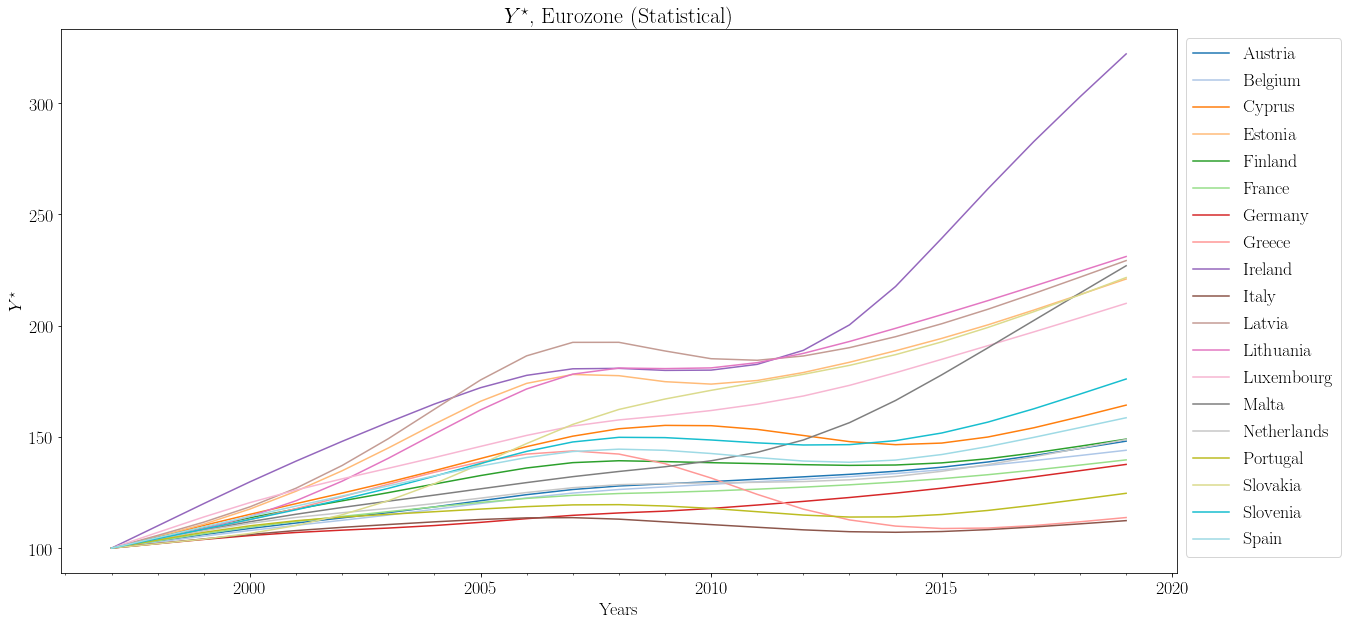

<Figure size 432x288 with 0 Axes>

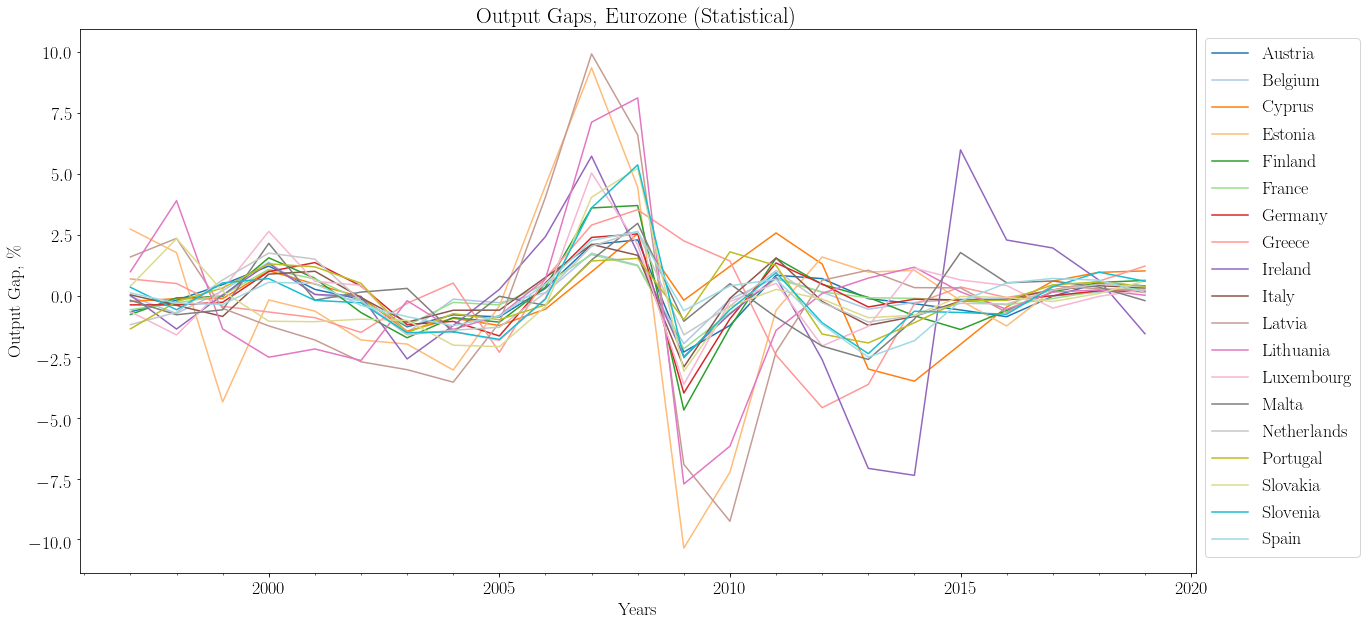

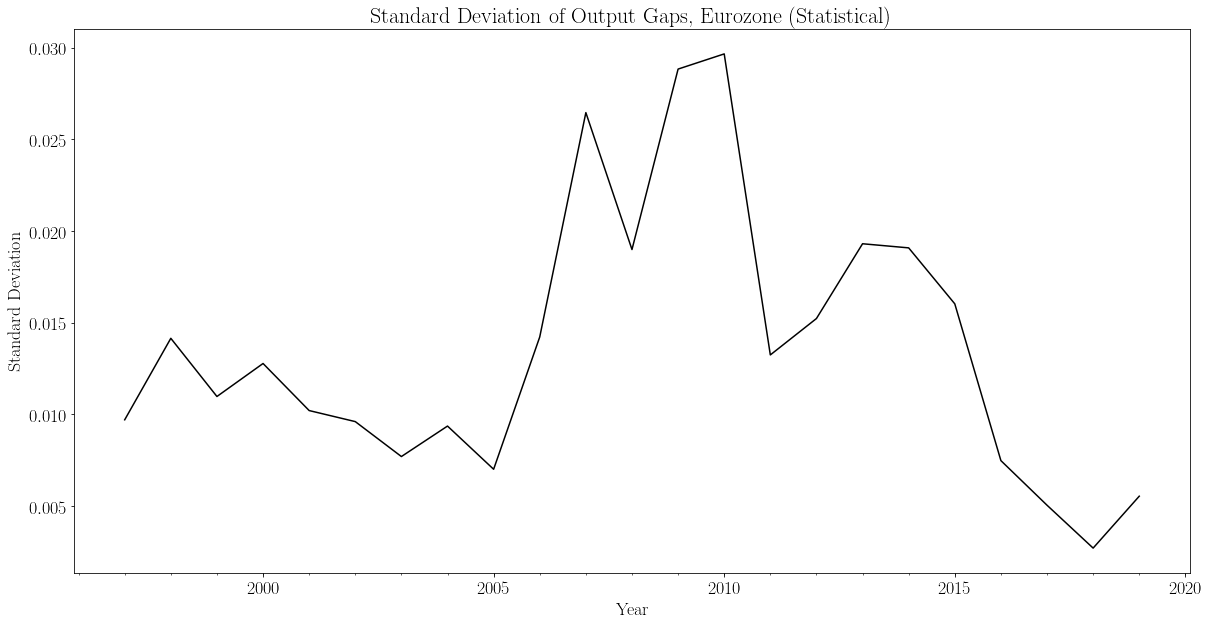

In [9]:
graphs_potential(statistical_gdp, statistical_potential, statistical_gap, "Statistical");

<br>

## $\textrm{Structural}$

In [10]:
def structural(data_input, study_countries):

    study_years = [i for i in range(1997, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    data_input=data_input[data_input.year >= 1997]
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.set_index("year")

        # Calculate α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        
        # Calculate TFP
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
        
        # Calculate natural rate of unemployment
        _, country_indicators["NRU"] = sm.tsa.filters.hpfilter(country_indicators["ZUTN"].values, 6.25)
        
        # Calculate trend and gap
        output_trend[country] = country_indicators["TFP"]*(country_indicators["OKND"].pow(country_indicators["α"])*
                                                           (country_indicators["NLTN"]*(-country_indicators["NRU"]+1)).pow(-country_indicators["α"]+1))
        
        output_cycle[country] = country_indicators["OVGD"]-output_trend[country]
        
    gap = output_cycle.dropna(axis=1).astype(float); gap.index = pd.to_datetime(gap.index, format='%Y')
    potential = output_trend.dropna(axis=1).astype(float); potential.index = pd.to_datetime(potential.index, format='%Y')
            
    return(potential+gap, potential, gap)

In [11]:
structural_gdp, structural_potential, structural_gap = structural(data, study_countries)

<br>

<Figure size 432x288 with 0 Axes>

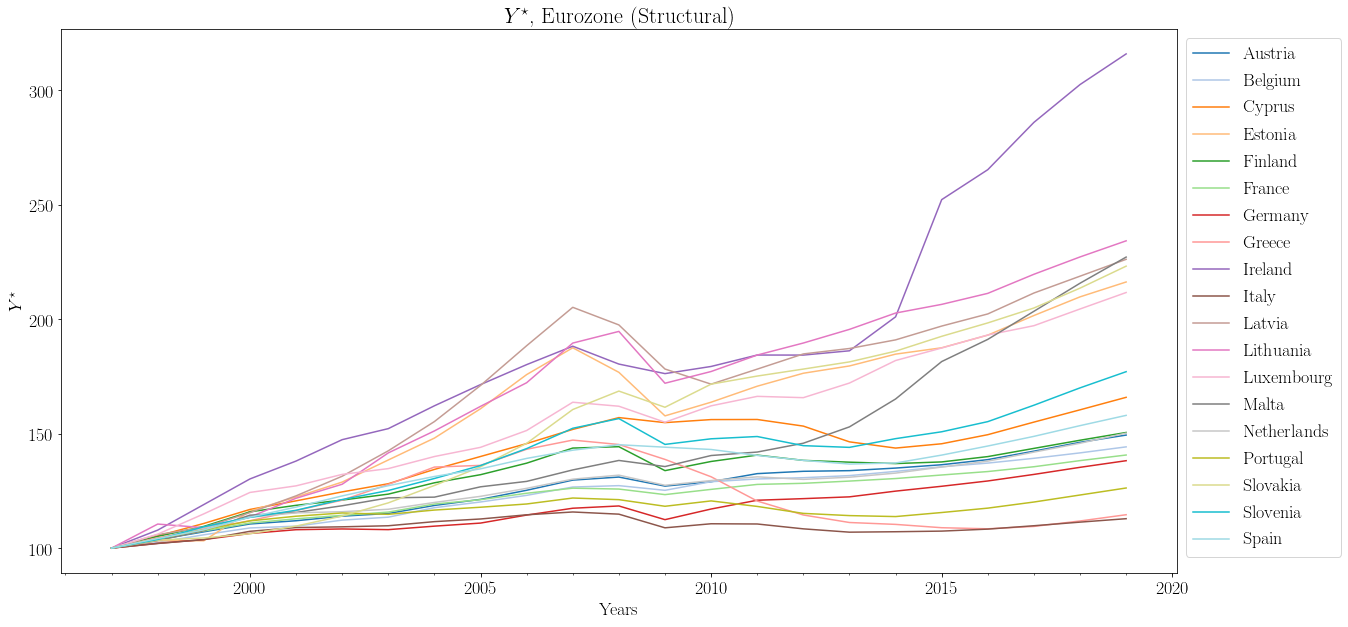

<Figure size 432x288 with 0 Axes>

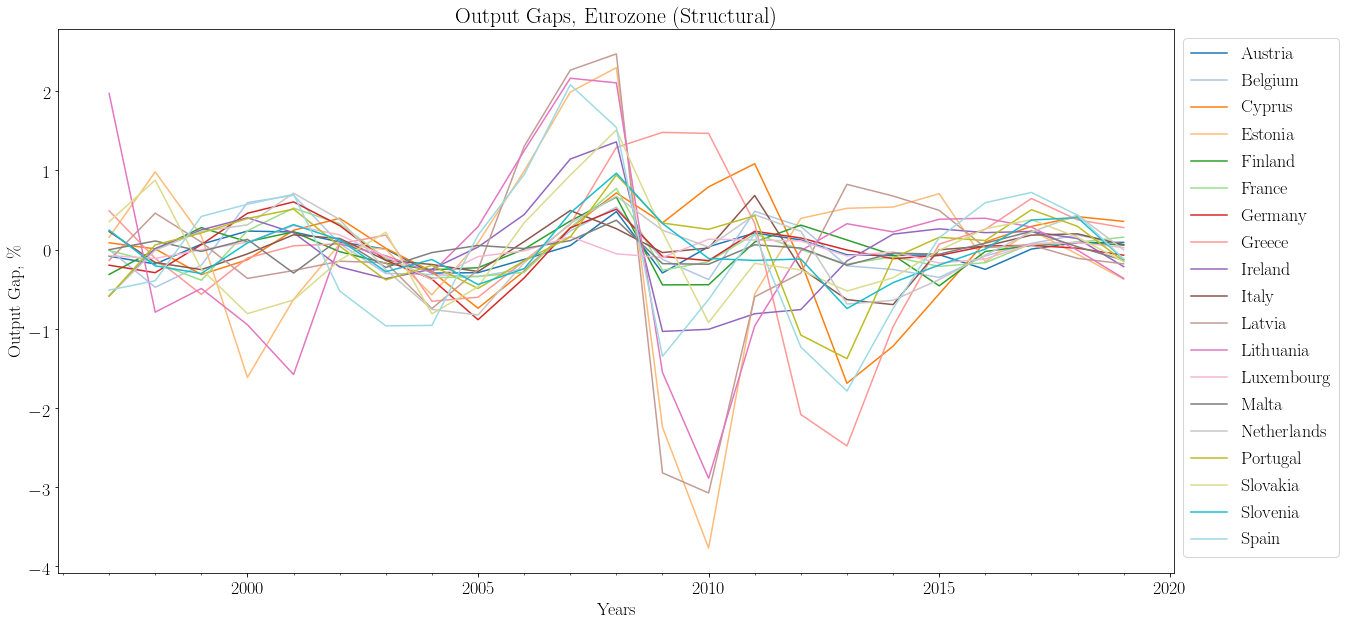

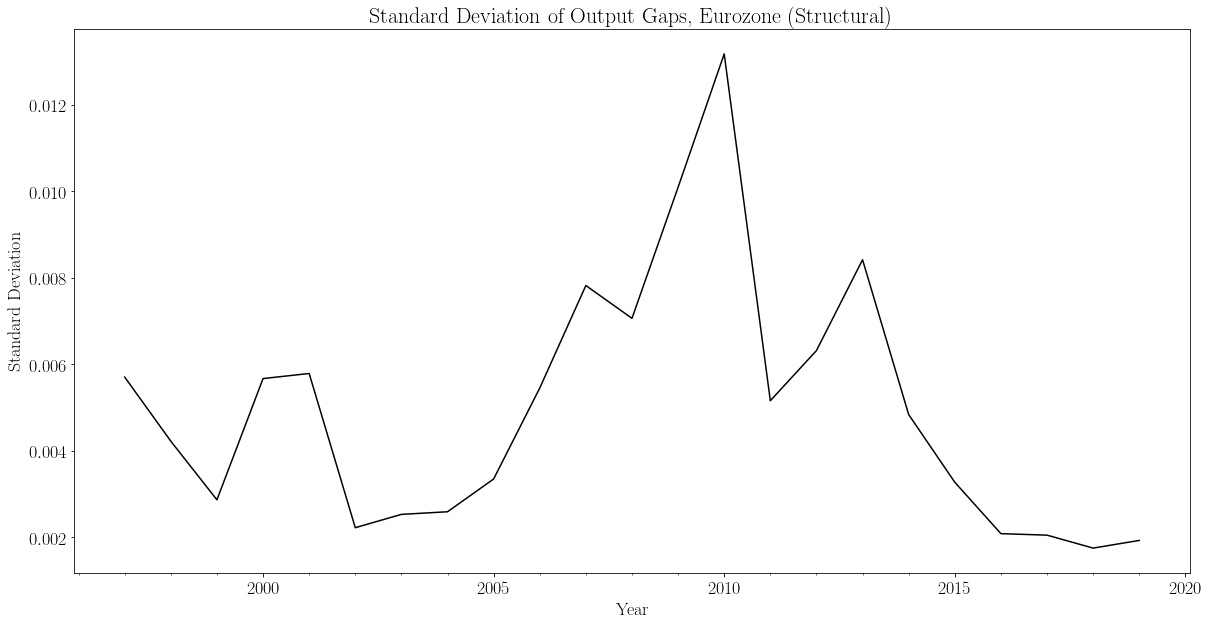

In [12]:
graphs_potential(structural_gdp, structural_potential, structural_gap, "Structural")

<br>

<br>

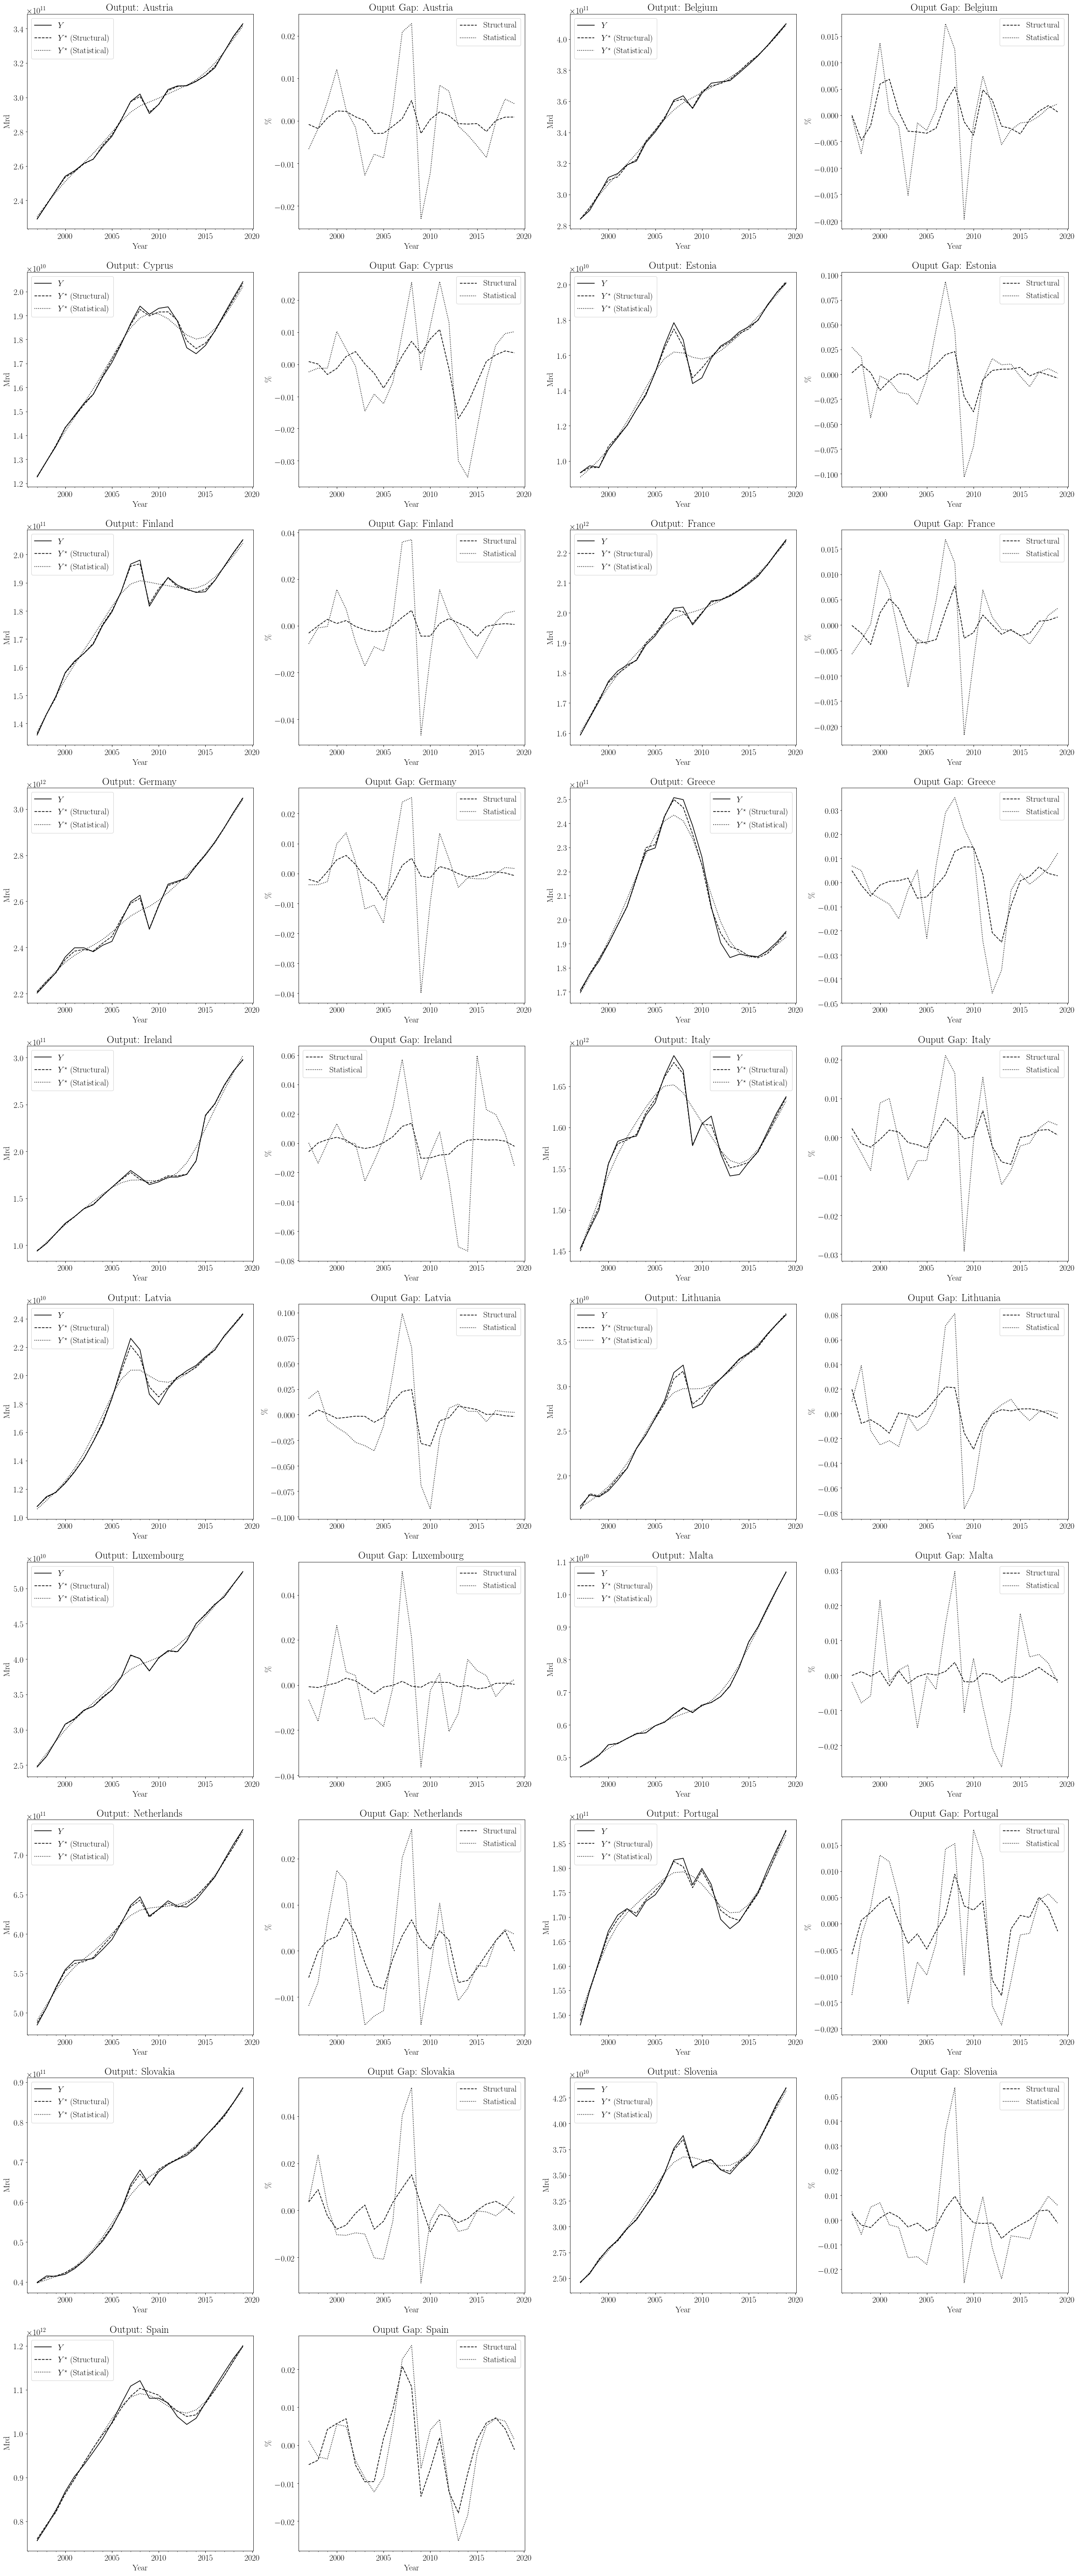

In [13]:
f, axes = plt.subplots(nrows=10, ncols=4, figsize=(40, 100)); axes = axes.flatten(); f.delaxes(axes[38]); f.delaxes(axes[39]); 
for i, country in enumerate(study_countries):
    df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
    df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
    df_temp1.plot(style=['-','--',':'], color="black", ax=axes[i*2])
    axes[i*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
    axes[i*2].set_title("Output: "+country, fontsize=22)
    axes[i*2].set_ylabel("Mrd")
    axes[i*2].set_xlabel("Year")

    df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
    df_temp2["Structural"] = structural_gap[country]/OVGD[country]; df_temp2["Statistical"] = statistical_gap[country]/OVGD[country] 
    df_temp2.plot(style=['--',':'], color="black", ax=axes[i*2+1])
    axes[i*2+1].legend(labels=["Structural", "Statistical"])
    axes[i*2+1].set_title("Ouput Gap: "+country, fontsize=22)
    axes[i*2+1].set_ylabel("\%")
    axes[i*2+1].set_xlabel("Year")

_______

# $\textrm{Clustering and Correlations}$

In [14]:
def k_elbow(stat_gap, stat_gdp, stru_gap, stru_gdp):
    
    f, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
    
    data_kmeans = (stat_gap/stat_gdp).T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    res = list()
    n_cluster = range(2,15)
    for n in n_cluster:
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit(X)
        res.append(np.average(np.min( cdist(X.reshape(shape), km.cluster_centers_.reshape((n, shape[1]))), axis=1)))
           
    axes[0].plot(n_cluster, res)
    axes[0].set_title("Cluster Selection, Elbow Criterion (Statistical)", fontsize=22)
    axes[0].set_ylabel("Distortion Score")
    axes[0].set_xlabel("Number of Clusters")
    
    
    data_kmeans = (stru_gap/stru_gdp).T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    res = list()
    n_cluster = range(2,15)
    for n in n_cluster:
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit(X)
        res.append(np.average(np.min( cdist(X.reshape(shape), km.cluster_centers_.reshape((n, shape[1]))), axis=1)))
          
    axes[1].plot(n_cluster, res)
    axes[1].set_title("Cluster Selection, Elbow Criterion (Structural)", fontsize=22)
    axes[1].set_ylabel("Distortion Score")
    axes[1].set_xlabel("Number of Clusters")

    plt.tight_layout()

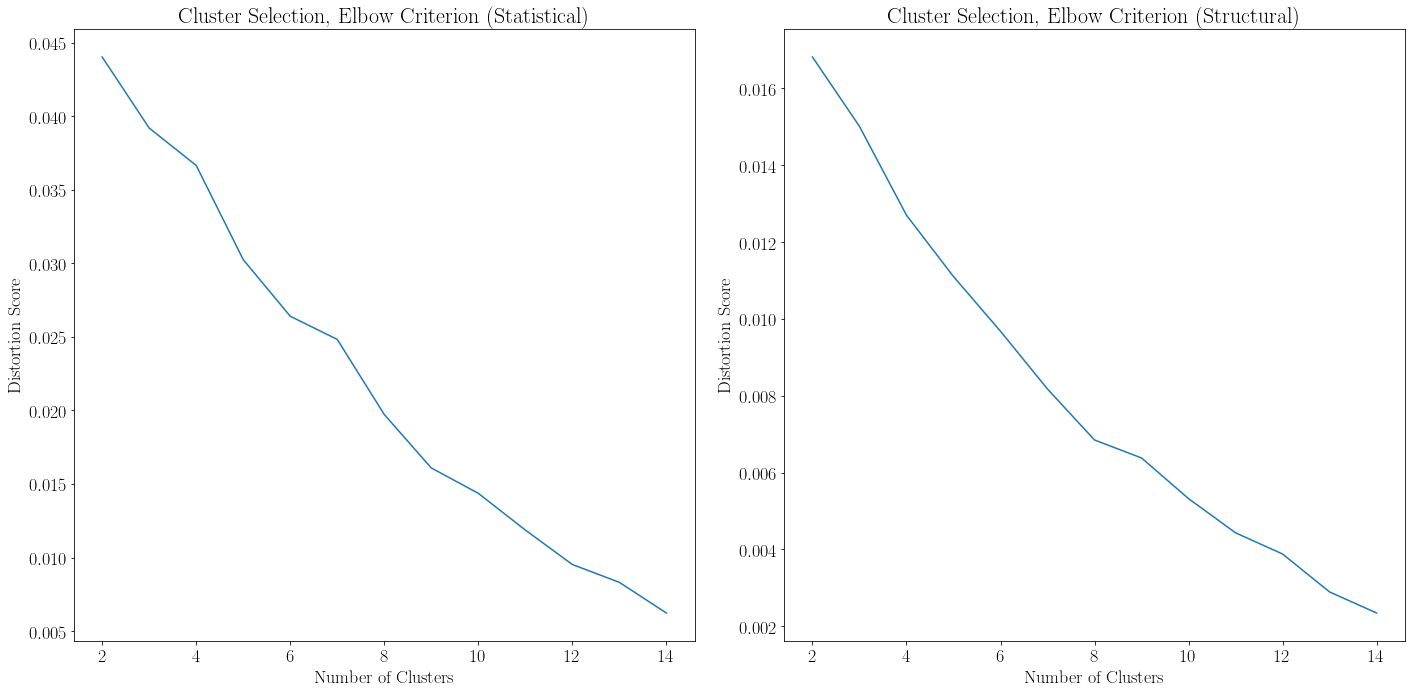

In [15]:
k_elbow(statistical_gap, statistical_gdp, structural_gap, structural_gdp)

<br>

In [16]:
def countries_k(gap, gdp, n):
    
    data_kmeans = (gap/gdp).T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit_predict(X)
    
    return(km)

In [17]:
def corrs_potential(sta_gap, stru_gap, sta_gdp, stru_gdp, extra):
    
    n = 4
    clusters_table = pd.DataFrame(np.array([countries_k(stru_gap, stru_gdp, n), countries_k(sta_gap, sta_gdp, n)]).T, 
                                  index=stru_gap.columns, columns=["Structural", "Statistical"])
    sta_order = clusters_table.sort_values("Statistical").Statistical.index.values
    stru_order = clusters_table.sort_values("Structural").Structural.index.values
    
    f, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    sns.heatmap(sta_gap[sta_order].corr(), mask=np.zeros_like(sta_gap[sta_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True, ax=axes[0]).set_title("Correlation Matrix of Output Gaps (Statistical)"+extra, fontsize=22)
    
    sns.heatmap(stru_gap[stru_order].corr(), mask=np.zeros_like(stru_gap[stru_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True, ax=axes[1]).set_title("Correlation Matrix of Output Gaps (Structural)"+extra, fontsize=22)
    
    plt.tight_layout()

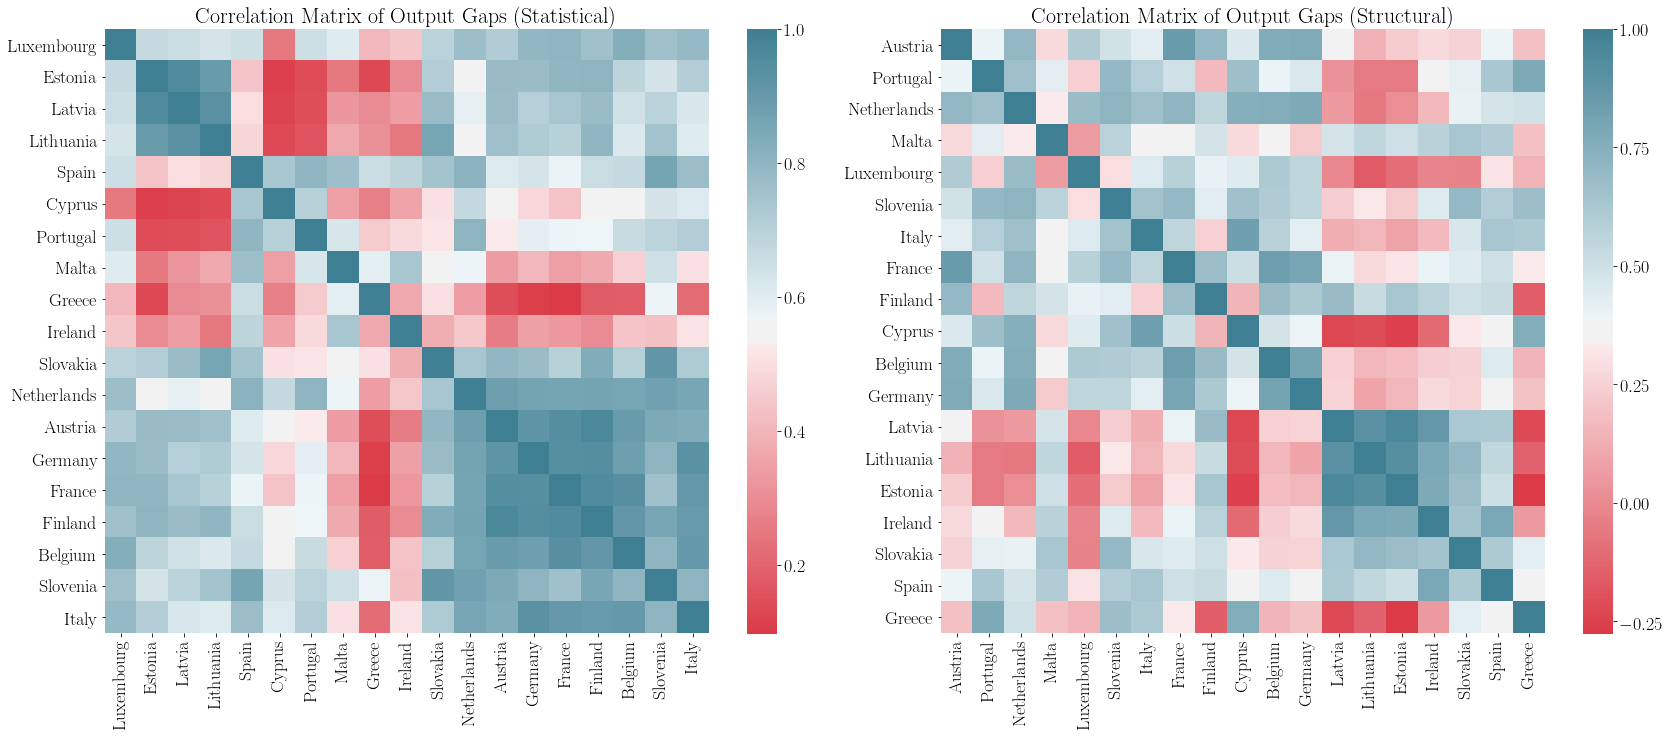

In [18]:
corrs_potential(statistical_gap, structural_gap, statistical_gdp, structural_gdp, "")

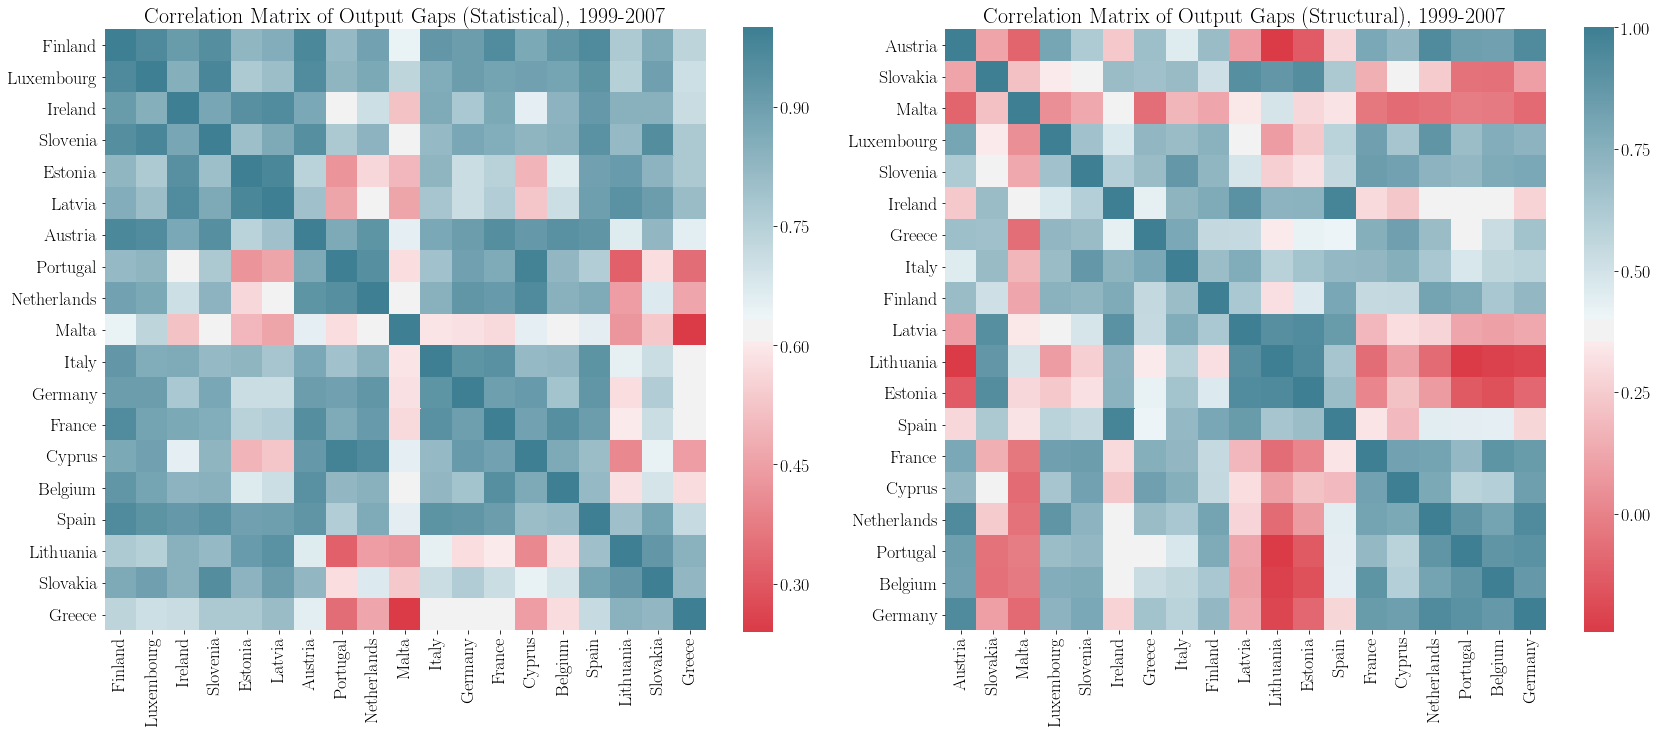

In [19]:
corrs_potential(statistical_gap.loc["1999-01-01" : "2007-01-01"], structural_gap.loc["1999-01-01" : "2007-01-01"], statistical_gdp.loc["1999-01-01" : "2007-01-01"], structural_gdp.loc["1999-01-01" : "2007-01-01"], ", 1999-2007")

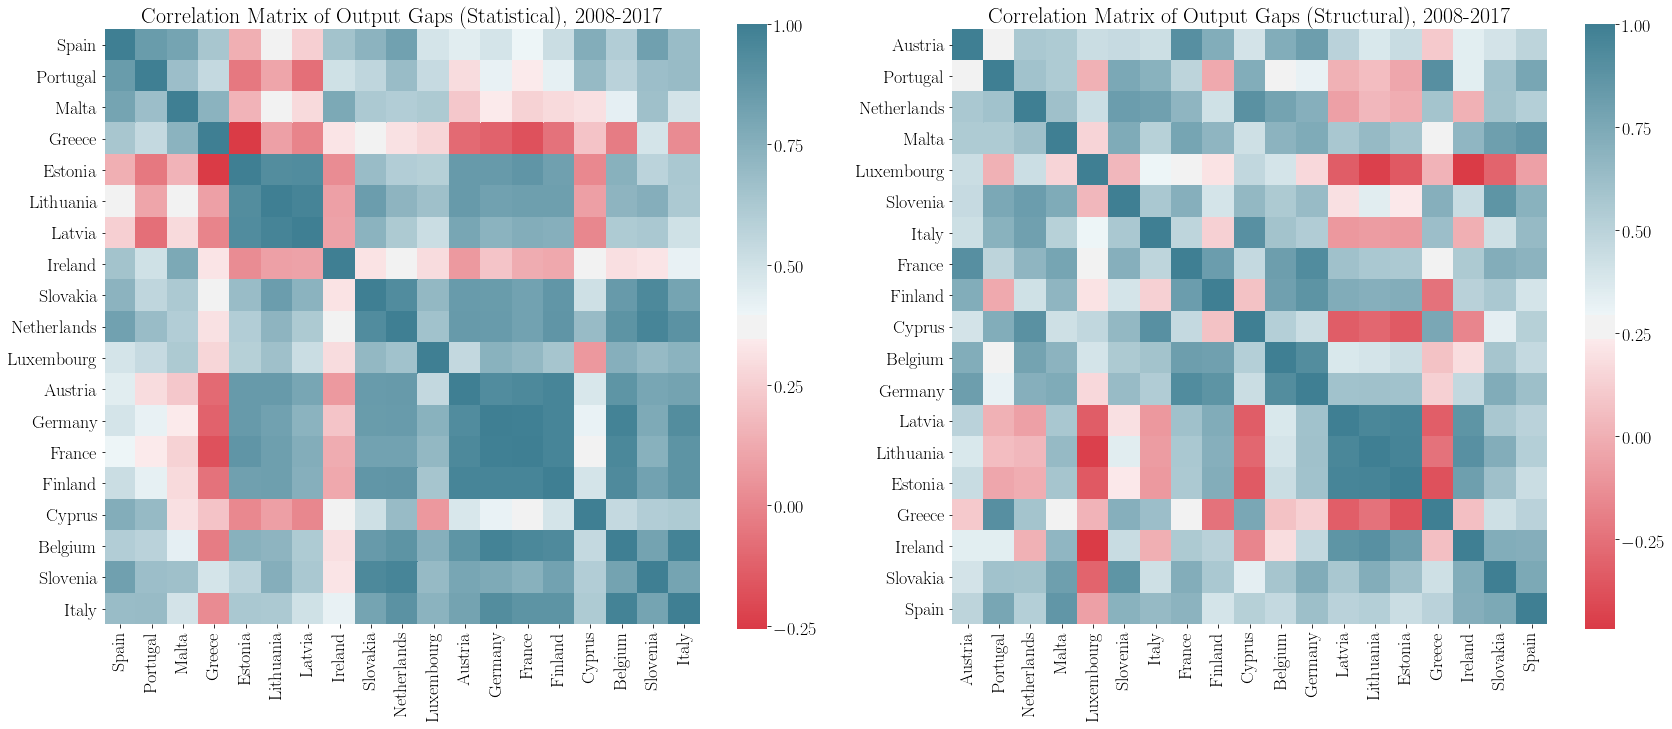

In [20]:
corrs_potential(statistical_gap.loc["2008-01-01" : "2017-01-01"], structural_gap.loc["2008-01-01" : "2017-01-01"], statistical_gdp.loc["2008-01-01" : "2017-01-01"], structural_gdp.loc["2008-01-01" : "2017-01-01"], ", 2008-2017")

<br>

____________

# $\textrm{Growth Accounting}$

In [21]:
def growth_decomposition(data_input, study_countries):

    study_years = [i for i in range(1997, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    data_input=data_input[data_input.year >= 1997]
    
    ΔGDP = pd.DataFrame(index=study_years[1:]);
    ΔTFP = ΔGDP.copy(); ΔK = ΔGDP.copy(); ΔαK = ΔGDP.copy(); ΔN = ΔGDP.copy(); Δ1αN = ΔGDP.copy(); Δα = ΔGDP.copy()
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.set_index("year")
        
        # Add ΔGDP
        ΔGDP[country] = country_indicators["OVGD"].pct_change().values[1:]
        
        #Calculate N
        country_indicators["N"] = (-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]
        # Add ΔN 
        ΔN[country] = country_indicators["N"].pct_change().values[1:]
        
        # Add ΔK
        ΔK[country] = country_indicators["OKND"].pct_change().values[1:]
                
        # Calculate α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        # Add Δα
        Δα[country] = country_indicators["α"].pct_change().values[1:]
        Δ1αN[country] = ((-country_indicators["α"]+1)*country_indicators["N"]).pct_change().values[1:]
        ΔαK[country] = (country_indicators["α"]*country_indicators["OKND"]).pct_change().values[1:]
        
        # Calculate TFP
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
        # Add ΔTFP
        ΔTFP[country] = country_indicators["TFP"].pct_change().values[1:]
                    
    return(ΔGDP*100, ΔTFP*100, ΔK*100, ΔαK*100, ΔN*100, Δ1αN*100, Δα*100)

In [22]:
ΔGDP, ΔTFP, ΔK, ΔαK, ΔN, Δ1αN, Δα = growth_decomposition(data, study_countries)

<br>

In [23]:
def graph_growth(Δ, indicator, extra):
        
    plt.figure()
    Δ.plot(figsize=(20, 10), colormap="tab20")
    plt.title(indicator+", Eurozone", fontsize=22)
    plt.ylabel(indicator+", \%")
    plt.xlabel("Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
        
    if extra==True:

        plt.figure()
        Δ.std(axis=1).plot(figsize=(20, 10), color='black')
        plt.title("Standard Deviation of "+indicator+", Eurozone", fontsize=22)
        plt.ylabel("sd("+indicator+")")
        plt.xlabel("Year")
        plt.show()
        
        n = 4
        data_kmeans = Δ.T
        X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
        shape = data_kmeans.shape
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit_predict(X)
        clusters_table = pd.DataFrame(np.array(km), index=Δ.columns, columns=["Cat"])
        corr_order = clusters_table.sort_values("Cat").Cat.index.values
        
        plt.figure(figsize=(14,10))
        sns.heatmap(Δ[corr_order].corr(), mask=np.zeros_like(Δ[corr_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True).set_title("Correlation Matrix of "+indicator+", Eurozone", fontsize=22)
        plt.show()

<Figure size 432x288 with 0 Axes>

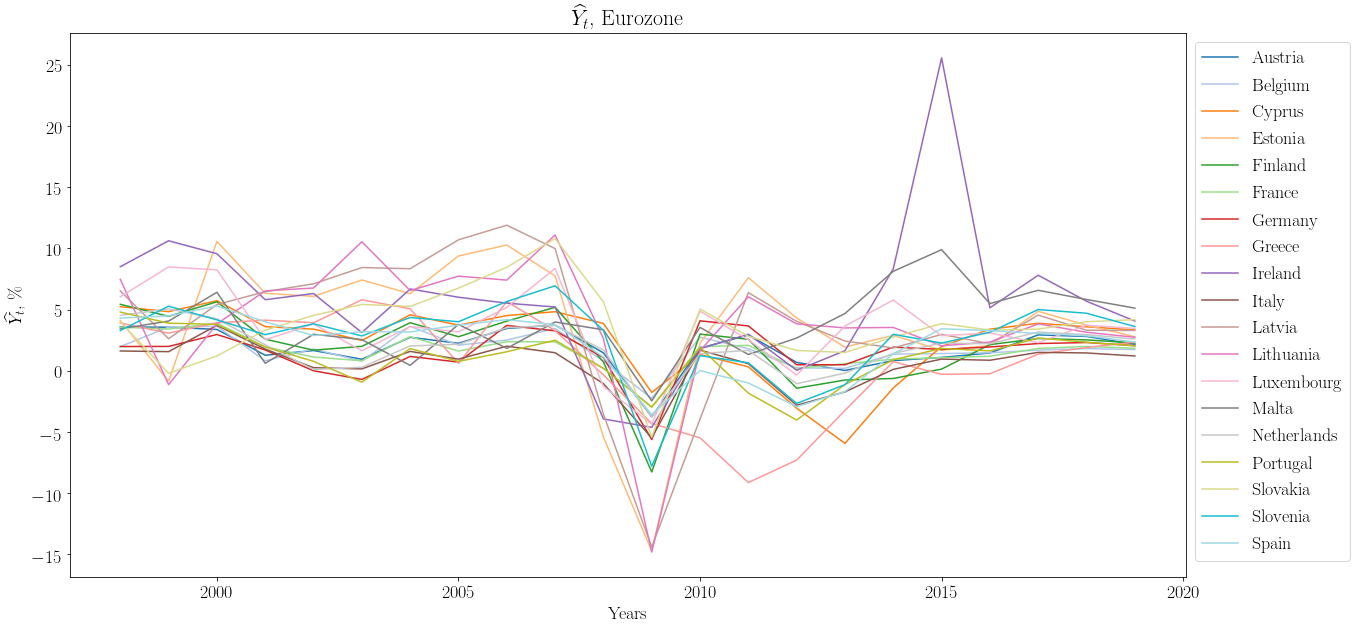

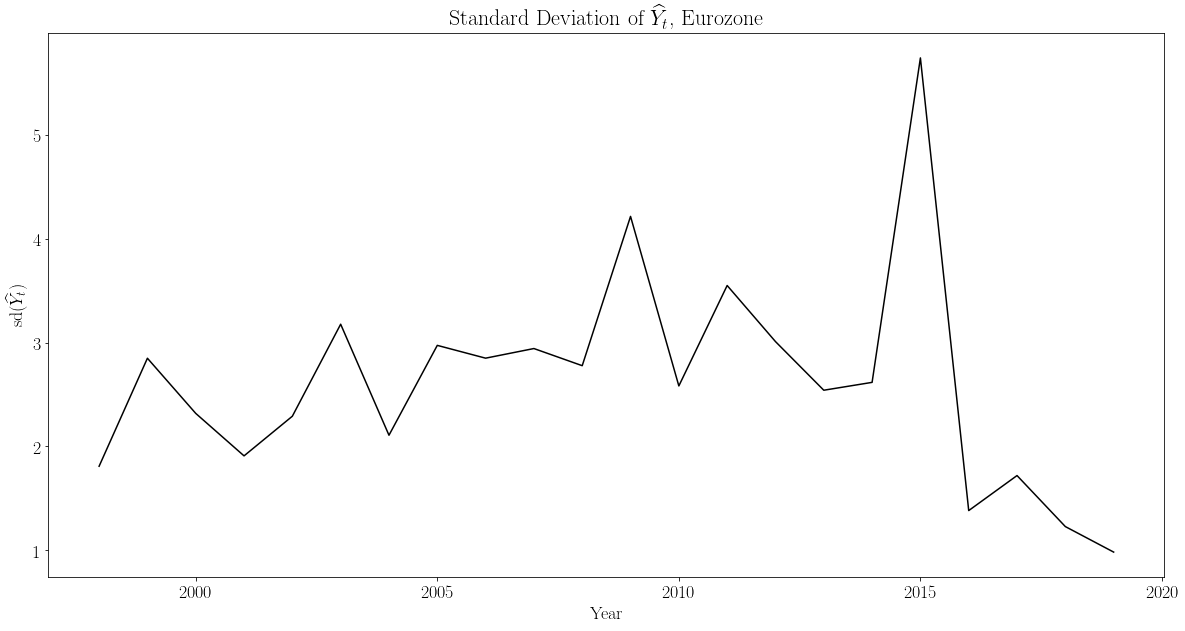

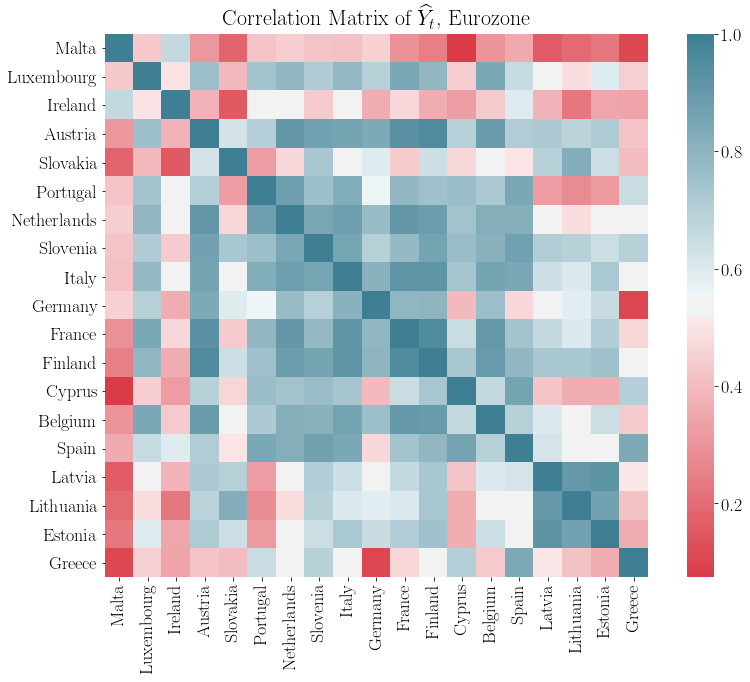

<Figure size 432x288 with 0 Axes>

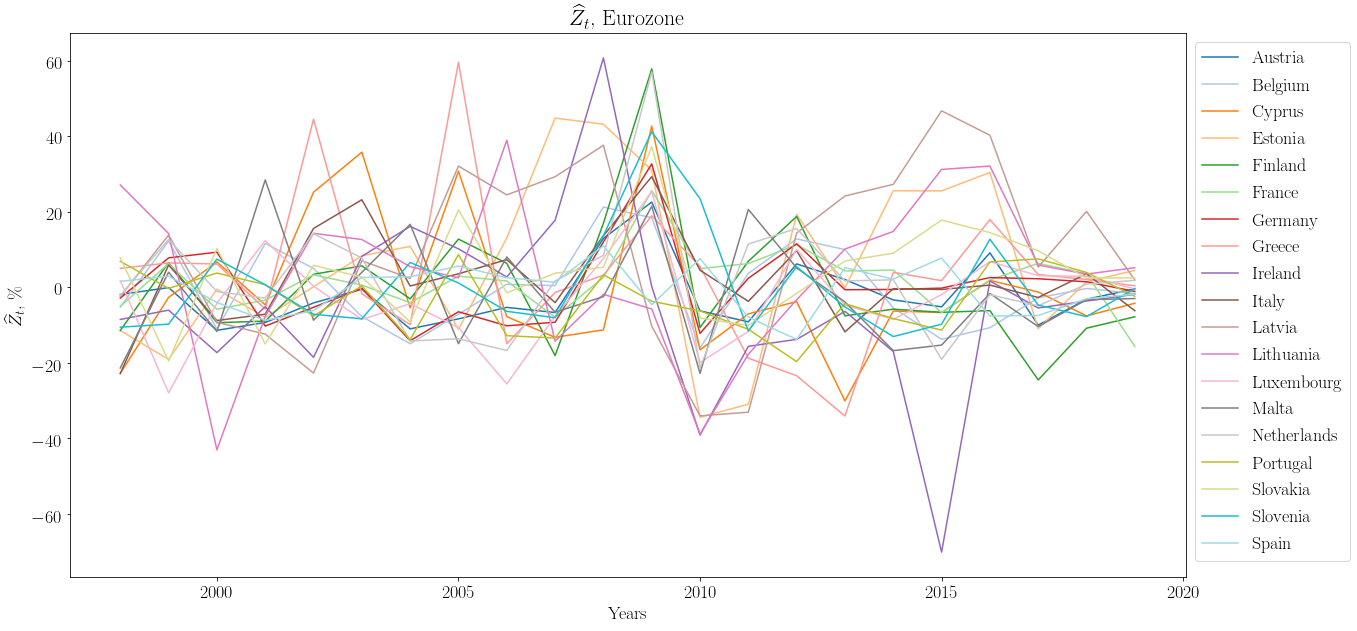

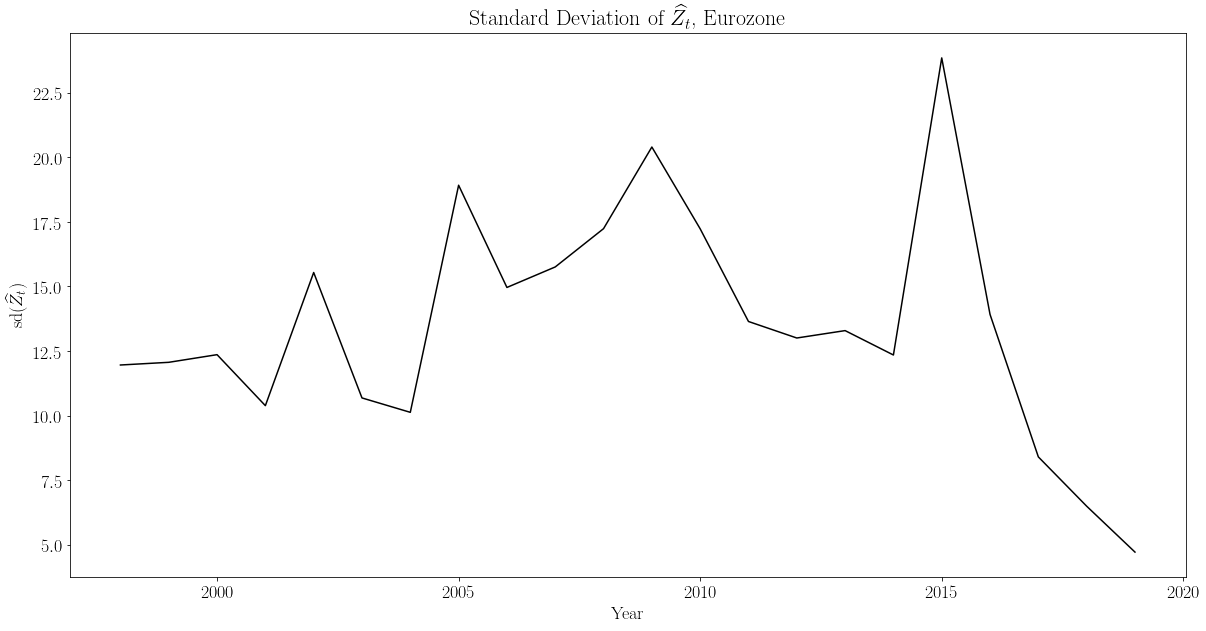

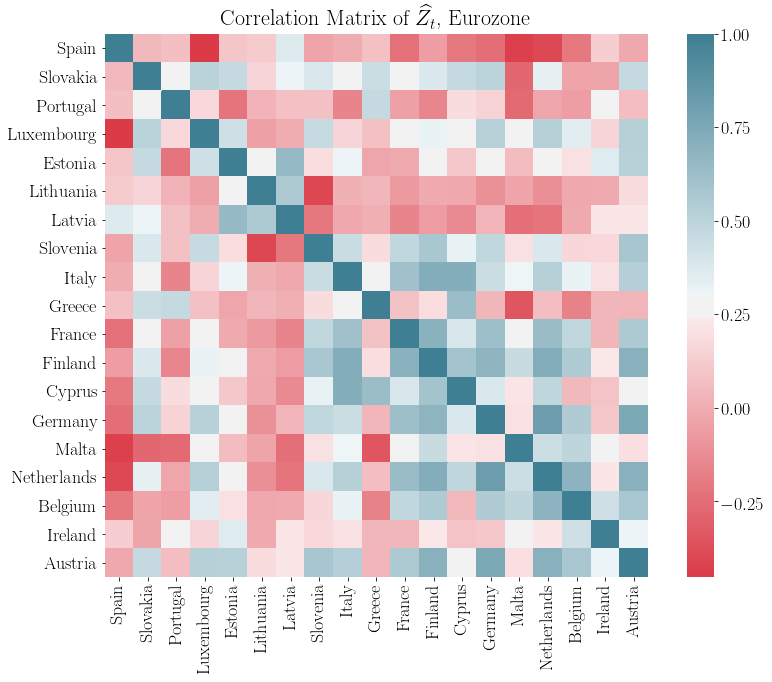

<Figure size 432x288 with 0 Axes>

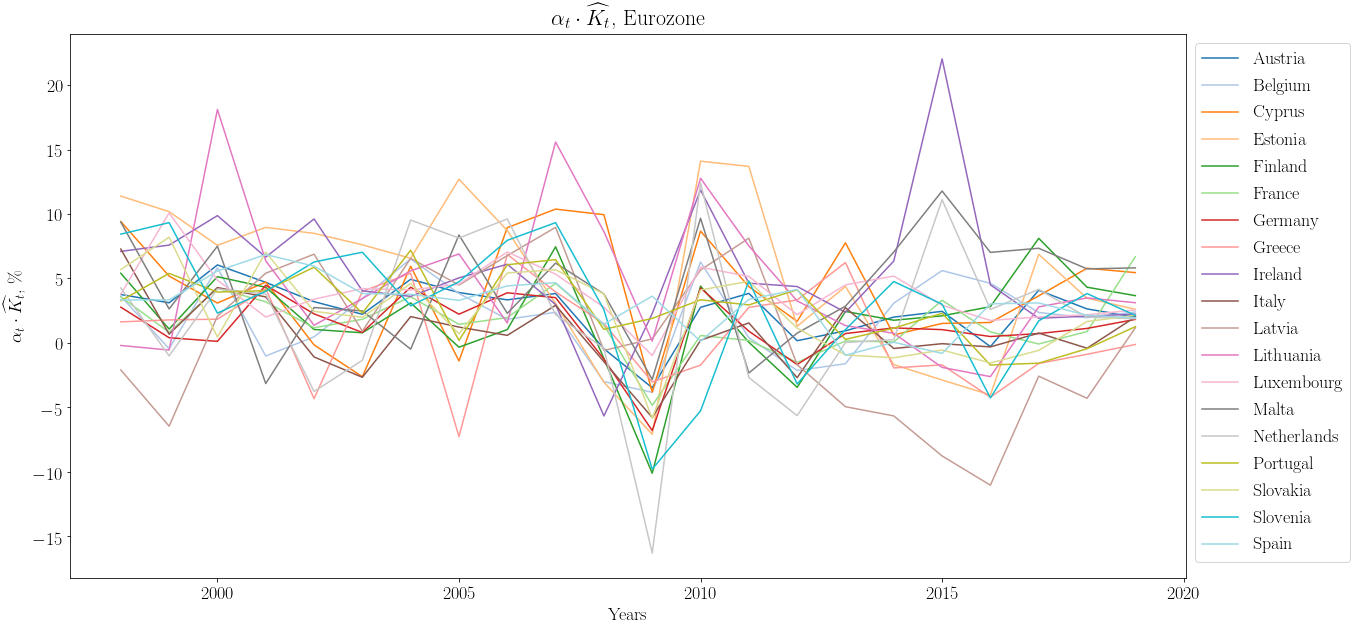

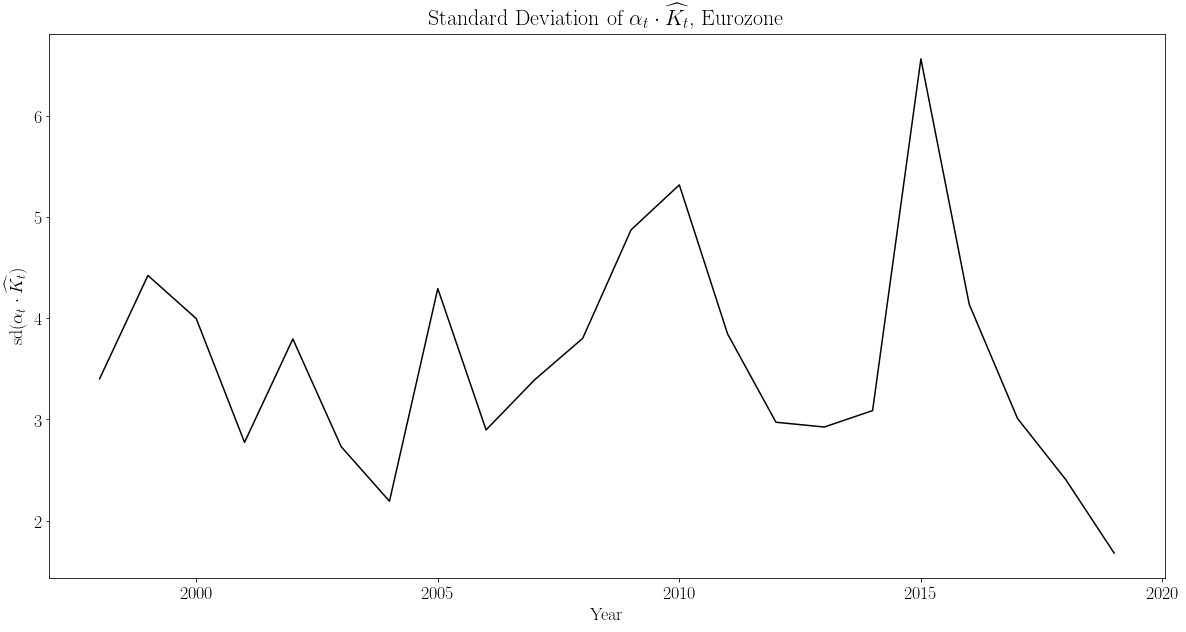

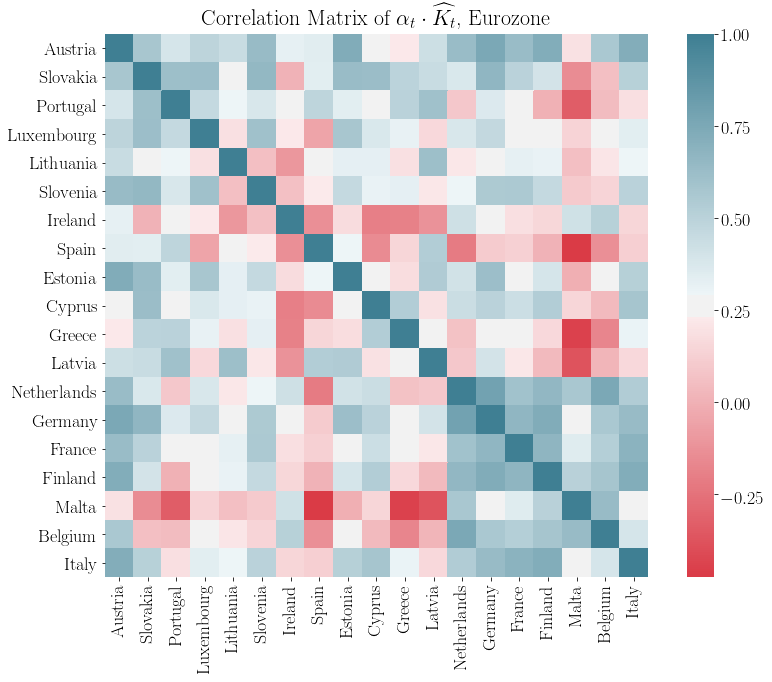

<Figure size 432x288 with 0 Axes>

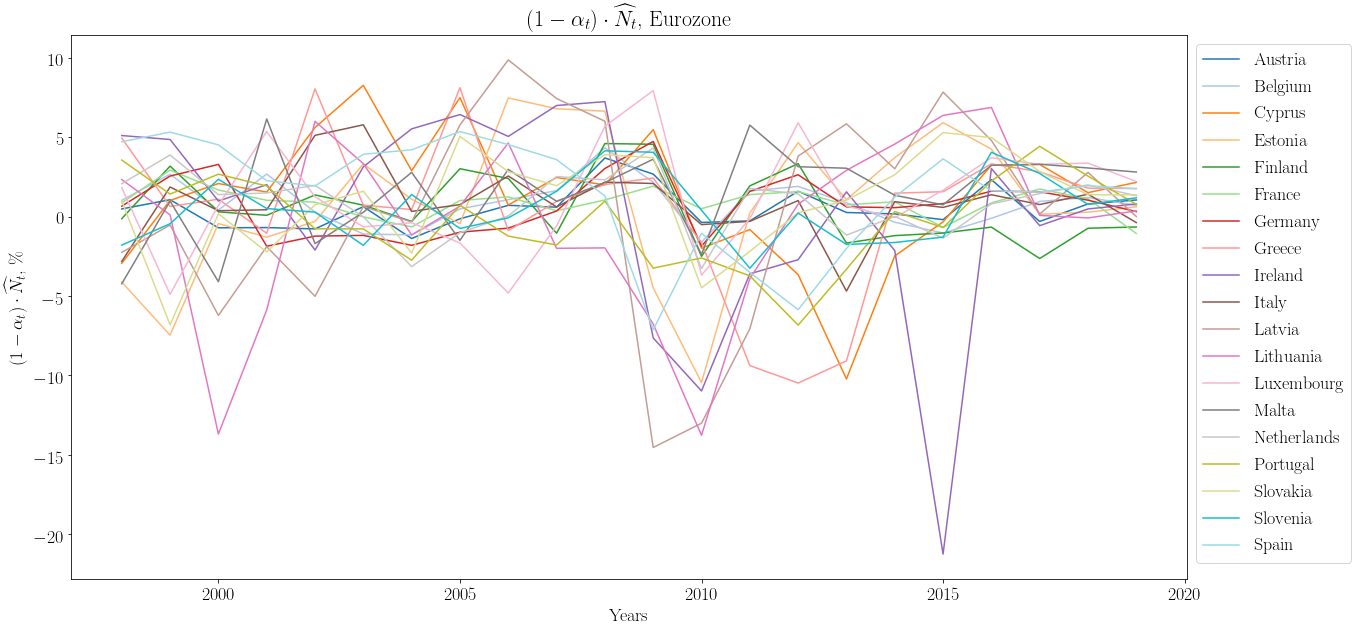

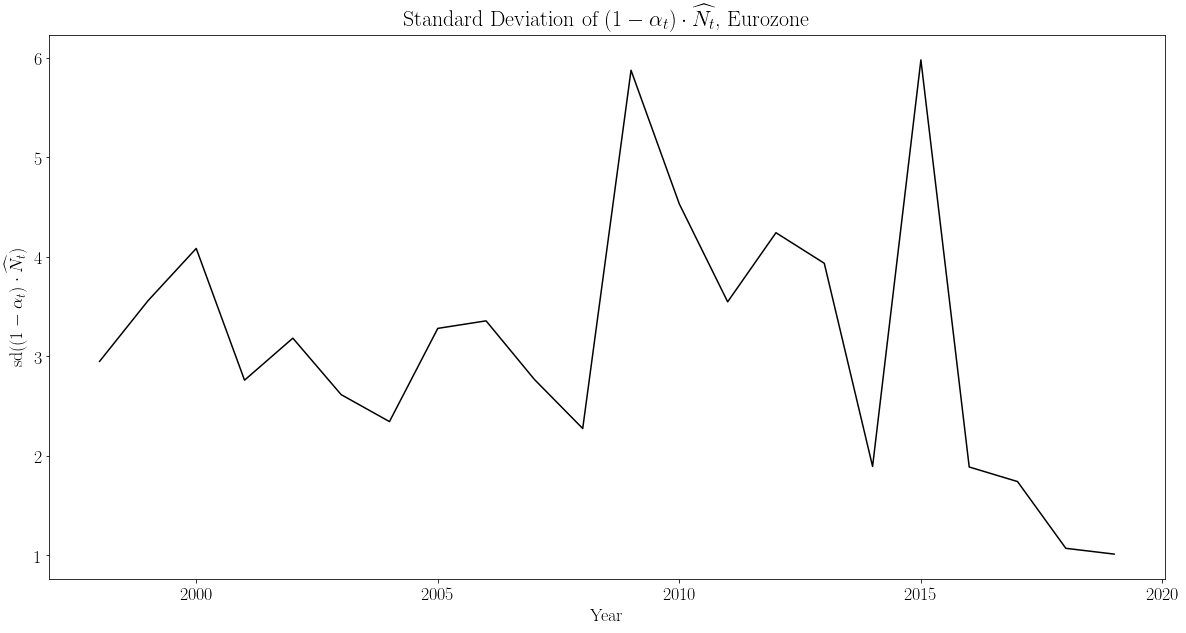

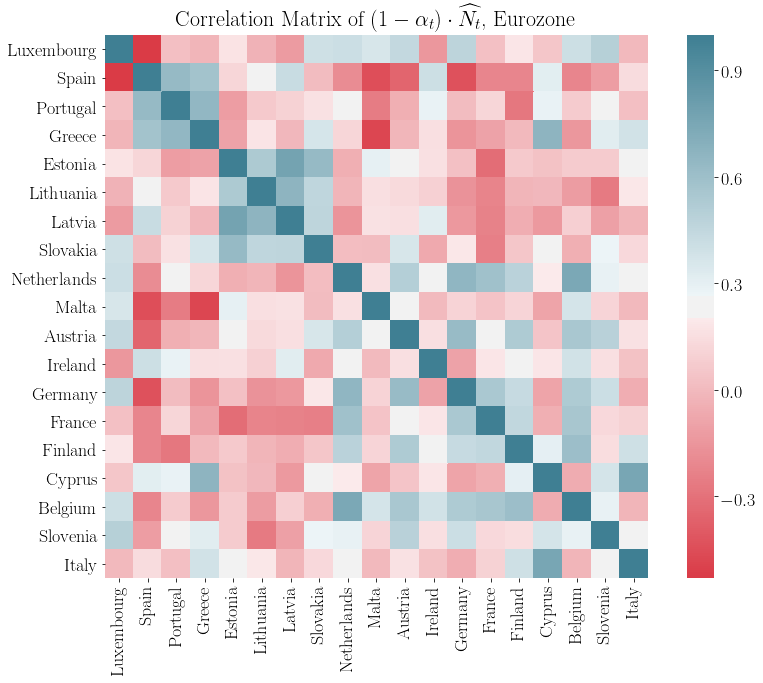

<Figure size 432x288 with 0 Axes>

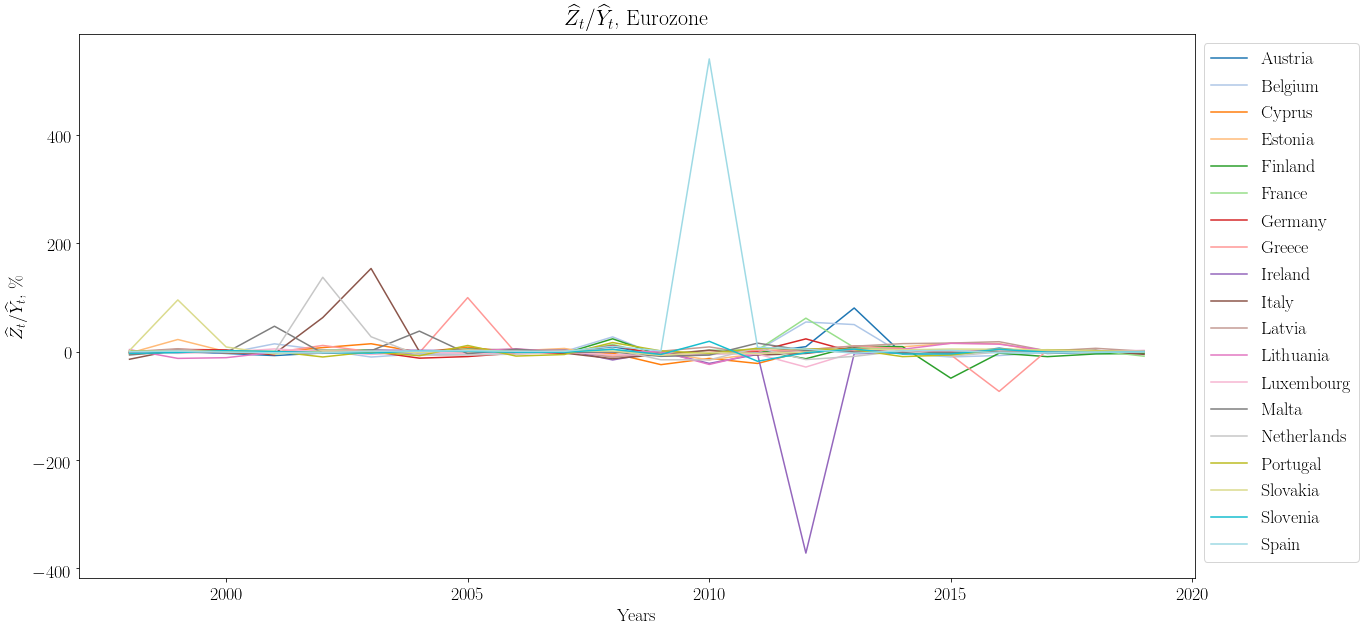

<Figure size 432x288 with 0 Axes>

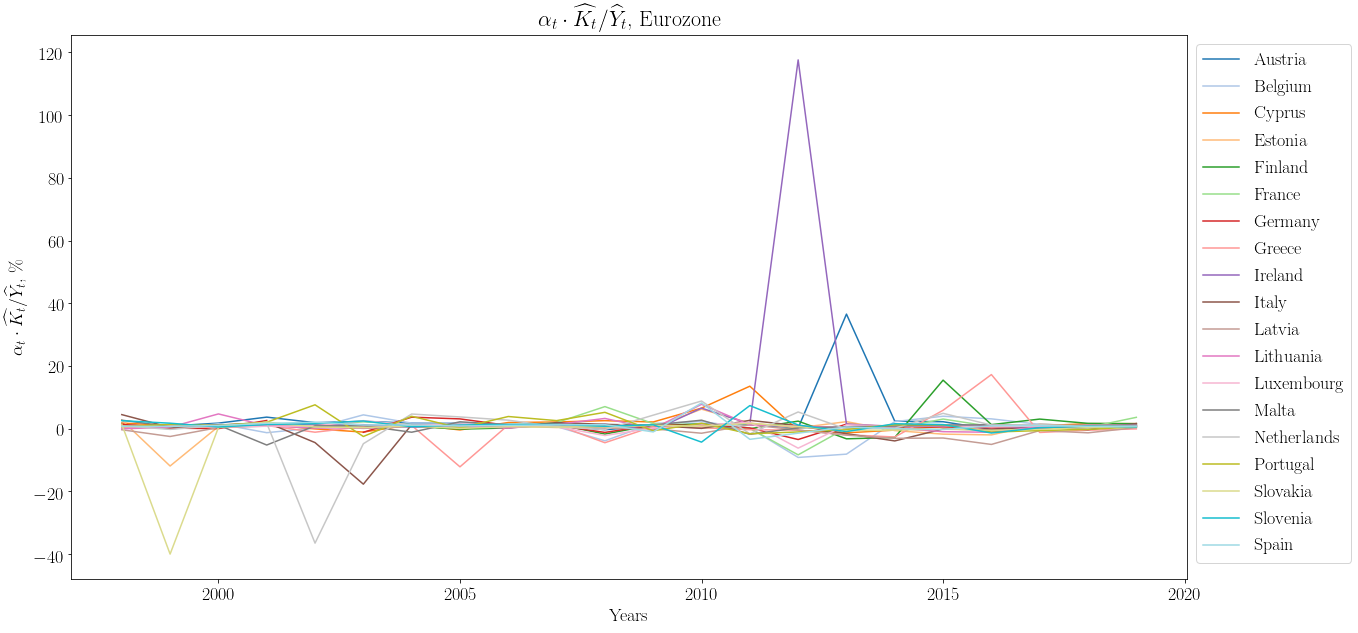

<Figure size 432x288 with 0 Axes>

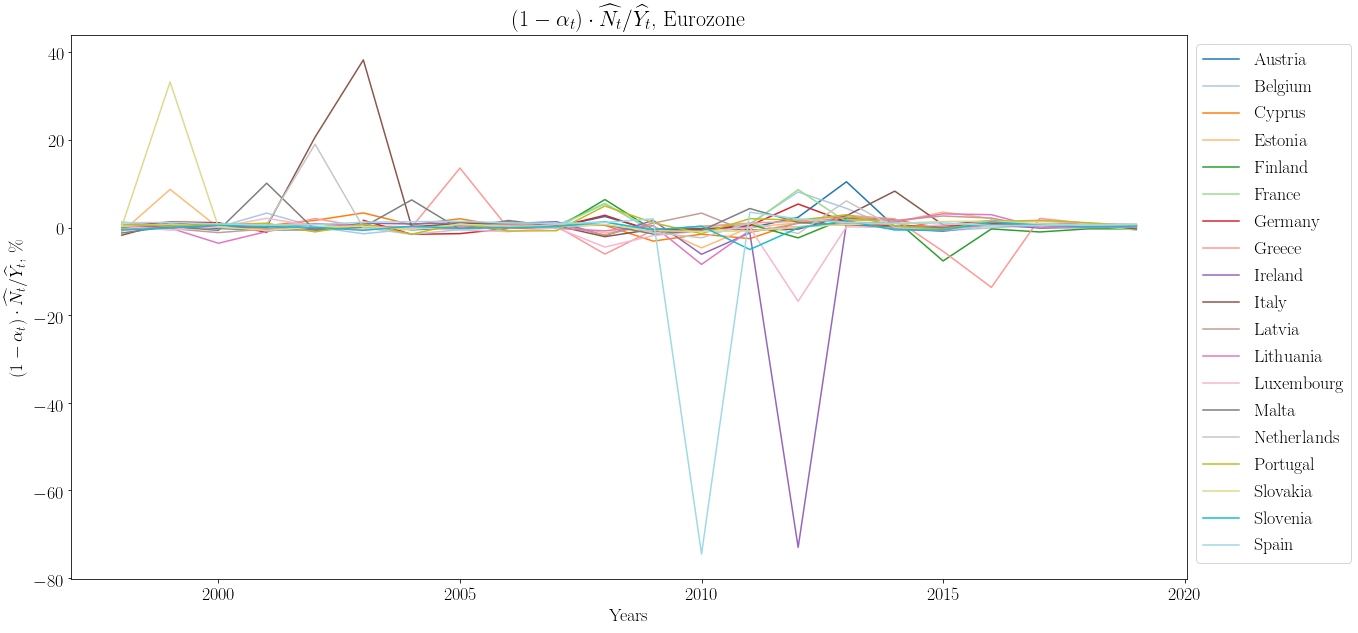

In [24]:
graph_growth(ΔGDP, r"$\widehat{Y_t}$", True)
graph_growth(ΔTFP, r"$ \widehat{Z_t}$", True)
graph_growth(ΔαK, r"$\alpha_t \cdot \widehat{K_t}$", True)
graph_growth(Δ1αN, r"$(1-\alpha_t) \cdot \widehat{N_t}$", True)

graph_growth(ΔTFP/ΔGDP, r"$ \widehat{Z_t}/\widehat{Y_t}$", False)
graph_growth(ΔαK/ΔGDP, r"$\alpha_t \cdot \widehat{K_t}/\widehat{Y_t}$", False)
graph_growth(Δ1αN/ΔGDP, r"$(1-\alpha_t) \cdot \widehat{N_t}/\widehat{Y_t}$", False)

<br>

___________

# $\textrm{Evolution of Efficient Steady States}$

In [25]:
def efficient_ss(data_input, study_countries, year_start, year_end):

    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN", "USGN"]
    data_input=data_input[(data_input.year >= year_start) & (data_input.year <= year_end)]
    
    solow = pd.DataFrame(index=["s", "A1997", "n", "δ", "α", "g", "γ", "ke", "ye"])
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.astype(float)
        
        # s
        s = np.mean(country_indicators["USGN"]/country_indicators["OVGD"])
        
        # n
        country_indicators["N"] = (-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]
        n = gmean(np.log(country_indicators["N"].values[1:])-np.log(country_indicators["N"].values[:-1])+1)-1
                
        # α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        α = np.mean(country_indicators["α"])
        
        # A1999, g, γ
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
               
        A_start = country_indicators["TFP"].values[0]; A_end= country_indicators["TFP"].values[-1]
        g = (A_end/A_start)**(1/(year_end-year_start+1))-1
        γ = g/(1-α)
        
        # δ
        δ = 0.1
        
        #k
        if n+δ+(1+n)*g<= 0:
            ke=0;ye=0
        else:
            ke = ((s*A_start)/(n+δ+(1+n)*g))**(1/(1-α))
            ye = A_start*ke**α
        
        solow[country] = [s, A_start, n, δ, α, g, γ, ke, ye]
        
    return(solow.transpose())

In [26]:
ss_bc = efficient_ss(data, study_countries, 1999, 2011)
ss_ac = efficient_ss(data, study_countries, 2012, 2019)

<br>

<Figure size 432x288 with 0 Axes>

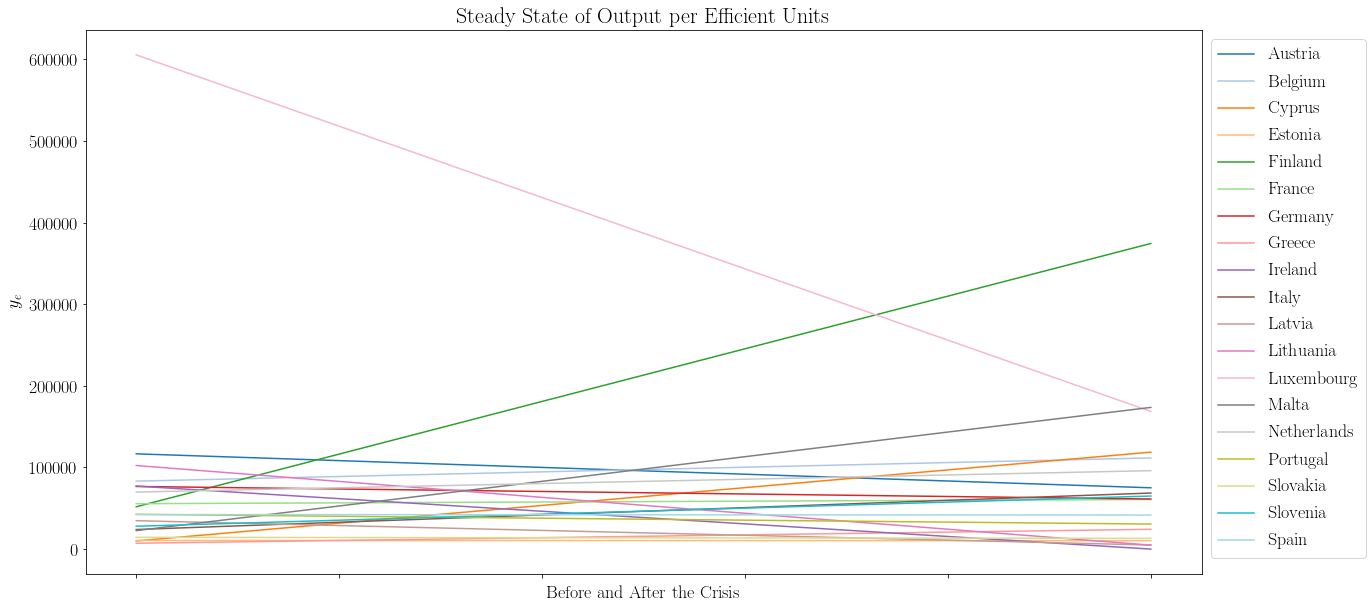

In [27]:
plt.figure()
pd.DataFrame(np.array([ss_bc.ye.values, ss_ac.ye.values]), columns=study_countries, index=["Before Crisis", "After Crisis"]).plot(figsize=(20, 10), colormap="tab20")
plt.title("Steady State of Output per Efficient Units", fontsize=22)
plt.ylabel(r"$y_e$")
plt.xlabel(r"Before and After the Crisis")
plt.legend(bbox_to_anchor=(1,1))
plt.show()    

<br>